### Importing libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import os

### Importing the dataset

In [3]:
data=pd.read_excel(r"D:\Crudeoil price prediction\Crude Oil Prices Daily.xlsx")
data.head()

,Date,Closing Value
0,1986-01-02,25.56
1,1986-01-03,26.00
2,1986-01-06,26.53
3,1986-01-07,25.85
4,1986-01-08,25.87


### Handling missing values

In [4]:
data.isnull().any()

Date             False
Closing Value     True
dtype: bool

In [5]:
data.isnull().sum()

Date             0
Closing Value    7
dtype: int64

In [6]:
data.dropna(axis=0,inplace=True)

In [7]:
data=data.reset_index()['Closing Value']

In [8]:
data.head()

0    25.56
1    26.00
2    26.53
3    25.85
4    25.87
Name: Closing Value, dtype: float64

### Feature scaling

In [9]:
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler(feature_range=(0,1))
data=scaler.fit_transform(np.array(data).reshape(-1,1))

In [10]:
data

array([[0.11335703],
       [0.11661484],
       [0.12053902],
       ...,
       [0.46497853],
       [0.47038353],
       [0.47149415]])

In [11]:
len(data)

8216

### Data visualization

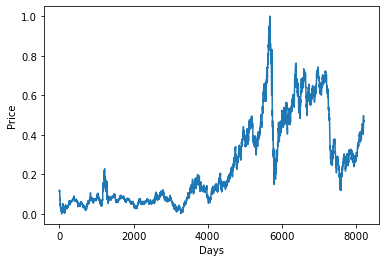

In [12]:
plt.plot(data)
plt.xlabel("Days")
plt.ylabel("Price")
plt.show()

### Testing and training 

In [49]:
training_size=int(len(data)*0.80)
testing_size=len(data)-training_size
train_data,test_data=data[0:training_size],data[training_size:len(data)]

In [50]:
train_data.shape
len(test_data)

1644

### Sliding window

In [51]:
def create_dataset(dataset,timestep):
    dataX,dataY=[],[]
    for i in range(len(dataset)-timestep-1):
        a=dataset[i:(i+timestep),0]
        dataX.append(a)
        dataY.append(dataset[i+timestep,0])
    return np.array(dataX),np.array(dataY)

In [52]:
time_step=10
x_train,y_train=create_dataset(train_data,time_step)
x_test,y_test=create_dataset(test_data,time_step)


In [54]:
y_train=y_train.reshape(-1,1)
y_test=y_test.reshape(-1,1)

In [55]:
print(x_train.shape)
print(y_test.shape)

(6561, 10)
(1633, 1)


### Model building

In [56]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

In [57]:
model=Sequential()

In [58]:
model.add(LSTM(50,return_sequences=True,input_shape=(10,1)))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))

In [59]:
model.add(Dense(1))

In [60]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 10, 50)            10400     
                                                                 
 lstm_4 (LSTM)               (None, 10, 50)            20200     
                                                                 
 lstm_5 (LSTM)               (None, 50)                20200     
                                                                 
 dense_1 (Dense)             (None, 1)                 51        
                                                                 
Total params: 50,851
Trainable params: 50,851
Non-trainable params: 0
_________________________________________________________________


In [61]:
model.compile(loss='mean_squared_error',optimizer='adam')

### Training the model

In [62]:
history=model.fit(x_train,y_train,validation_data=(x_test,y_test),epochs=50,batch_size=64,verbose=1)

Epoch 1/50
103/103 [==============================] - 11s 36ms/step - loss: 0.0057 - val_loss: 4.3634e-04
Epoch 2/50
103/103 [==============================] - 2s 21ms/step - loss: 3.5613e-04 - val_loss: 4.3645e-04
Epoch 3/50
103/103 [==============================] - 2s 20ms/step - loss: 3.3533e-04 - val_loss: 5.4420e-04
Epoch 4/50
103/103 [==============================] - 2s 20ms/step - loss: 3.4572e-04 - val_loss: 6.7273e-04
Epoch 5/50
103/103 [==============================] - 2s 20ms/step - loss: 3.3690e-04 - val_loss: 4.4779e-04
Epoch 6/50
103/103 [==============================] - 2s 21ms/step - loss: 3.3063e-04 - val_loss: 4.3494e-04
Epoch 7/50
103/103 [==============================] - 2s 21ms/step - loss: 3.3418e-04 - val_loss: 3.8758e-04
Epoch 8/50
103/103 [==============================] - 2s 20ms/step - loss: 3.0717e-04 - val_loss: 3.4249e-04
Epoch 9/50
103/103 [==============================] - 2s 21ms/step - loss: 3.1058e-04 - val_loss: 4.1184e-04
Epoch 10/50
103/103 [=

### Model evaluation

In [63]:
train_predict=model.predict(x_train)
test_predict=model.predict(x_test)

52/52 [==============================] - 0s 6ms/step


In [64]:
train_predict=scaler.inverse_transform(train_predict)
y_train=scaler.inverse_transform(y_train)
test_predict=scaler.inverse_transform(test_predict)
y_test=scaler.inverse_transform(y_test)

In [65]:
import math
from sklearn.metrics import mean_squared_error
math.sqrt(mean_squared_error(y_train,train_predict))

1.201985203053853

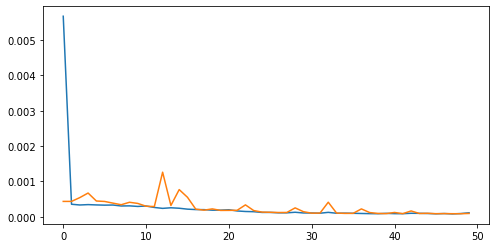

In [66]:
plt.figure(figsize=(8,4))
plt.plot(history.history['loss'],label='Train loss')
plt.plot(history.history['val_loss'],label='Test loss')
plt.show()

### saving and testing the model

In [67]:
from tensorflow.keras.models import load_model
model.save("crude_oil_forecasting.h5")

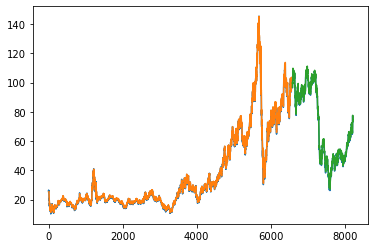

In [69]:
look_back=10
trainPredictPlot=np.empty_like(data)
trainPredictPlot[:,:]=np.nan
trainPredictPlot[look_back:len(train_predict)+look_back,:]=train_predict

testPredictPlot=np.empty_like(data)
testPredictPlot[:,:]=np.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(data)-1,:]=test_predict

plt.plot(scaler.inverse_transform(data))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

In [70]:
len(test_data)

1644

In [71]:
x_input=test_data[1634:].reshape(1,-1)
x_input.shape

(1, 10)

In [73]:
temp_input=list(x_input)
temp_input=temp_input[0].tolist()
temp_input

[0.44172960165852215,
 0.48111950244335855,
 0.49726047682511476,
 0.4679401747371539,
 0.4729749740855915,
 0.47119798608026064,
 0.47341922108692425,
 0.4649785280616022,
 0.4703835332444839,
 0.47149415074781587]

In [76]:
lst_output=[]
n_steps=10
i=0
while(i<10):
    if(len(temp_input)>10):
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input=x_input.reshape(1,n_steps,1)
        
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        lst_output.extend(yhat.tolist())
        i+=1
    else:
        x_input=x_input.reshape(1,n_steps,1)
        yhat = model.predict(x_input, verbose=0)
        
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1

[0.47472608]
11
1 day input [0.4811195  0.49726048 0.46794017 0.47297497 0.47119799 0.47341922
 0.46497853 0.47038353 0.47149415 0.47472608]
1 day output [[0.47818857]]
2 day input [0.49726048 0.46794017 0.47297497 0.47119799 0.47341922 0.46497853
 0.47038353 0.47149415 0.47472608 0.47818857]
2 day output [[0.48155242]]
3 day input [0.46794017 0.47297497 0.47119799 0.47341922 0.46497853 0.47038353
 0.47149415 0.47472608 0.47818857 0.48155242]
3 day output [[0.48464656]]
4 day input [0.47297497 0.47119799 0.47341922 0.46497853 0.47038353 0.47149415
 0.47472608 0.47818857 0.48155242 0.48464656]
4 day output [[0.48771197]]
5 day input [0.47119799 0.47341922 0.46497853 0.47038353 0.47149415 0.47472608
 0.47818857 0.48155242 0.48464656 0.48771197]
5 day output [[0.4906423]]
6 day input [0.47341922 0.46497853 0.47038353 0.47149415 0.47472608 0.47818857
 0.48155242 0.48464656 0.48771197 0.49064231]
6 day output [[0.4934774]]
7 day input [0.46497853 0.47038353 0.47149415 0.47472608 0.47818857 

In [78]:
day_new=np.arange(1,11)
day_pred=np.arange(11,21)
len(data)

8216

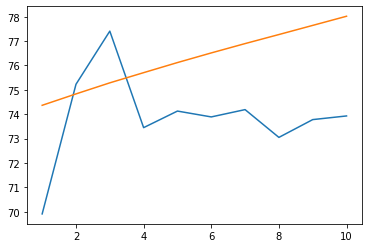

In [80]:
plt.plot(day_new,scaler.inverse_transform(data[8206:]))
plt.plot(day_new,scaler.inverse_transform(lst_output))

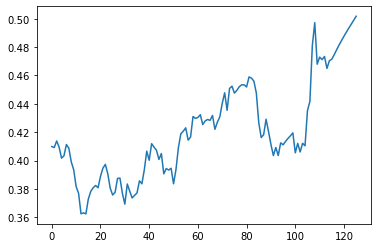

In [81]:
df3=data.tolist()
df3.extend(lst_output)
plt.plot(df3[8100:])

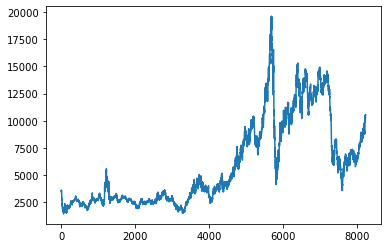

In [83]:
df3=scaler.inverse_transform(df3).tolist()
plt.plot(df3)